# Structure Data for BPNN

In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT LIBRARIES
from Dataset import *
import cupy as cp
from bpnn_cuda import BPNN
from tqdm import tqdm

def convert_categories(y_cat):
    desired = cp.array([0 if y[0] == 1 else 1 for y in y_cat])
    return desired

def get_data():
    d = Dataset.load_gzip(os.path.join(
        "datasets", "face_mask_pickled"), "dataset_gray_conv_test_1.pkl.gzip")

    ndimen = d.train.X.shape[1]

    # Structure Training Data for BPNN
    training_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.train.X]
    training_results = [cp.asarray(y.reshape(-1, 1)) for y in d.train.y]

    training_data = zip(training_inputs, training_results)
    # Structure Validation Data for BPNN
    validation_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.validation.X]
    validation_data = zip(validation_inputs, convert_categories(d.validation.y))
    # Structure Testing Data for BPNN
    testing_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.test.X]
    testing_data = zip(testing_inputs, convert_categories(d.test.y))

    return training_data, validation_data, testing_data, ndimen


training_data, validation_data, testing_data, ndimen = get_data()
print(f"Input Dimension: {ndimen}")

ntrials = 1
max_epochs = 15
init_nc = [ndimen, 200, 2]
init_b = 40
init_lr = 0.5

Input Dimension: 900


# Train Initial BPNN Configuration

In [31]:

model_BPNN = BPNN(init_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, conv_time = model_BPNN.train(training_data,
                                                                           max_epochs=max_epochs,
                                                                           batch_size=init_b,
                                                                           learning_rate=init_lr,
                                                                           evaluation_data=validation_data)


# Training MLP Network: Sizes=[900, 200, 2]	Epochs=15	Batch-Size=40	Learning-Rate=0.5
 - Training Data Len: 10000
 - Validation Data Len: 800
# Epochs:


  0%|          | 0/15 [00:00<?, ?it/s]

	1. Correct 683/800	(score: 0.85375	delta: 0.85375	delta_avg: 0.85375)
	2. Correct 720/800	(score: 0.9	delta: 0.04625000000000001	delta_avg: 0.45)
	3. Correct 730/800	(score: 0.9125	delta: 0.012499999999999956	delta_avg: 0.30416666666666664)
	4. Correct 740/800	(score: 0.925	delta: 0.012500000000000067	delta_avg: 0.23125)
	5. Correct 742/800	(score: 0.9275	delta: 0.0024999999999999467	delta_avg: 0.1855)
	6. Correct 744/800	(score: 0.93	delta: 0.0025000000000000577	delta_avg: 0.155)
	7. Correct 742/800	(score: 0.9275	delta: -0.0025000000000000577	delta_avg: 0.1325)
	8. Correct 740/800	(score: 0.925	delta: -0.0024999999999999467	delta_avg: 0.115625)
	9. Correct 741/800	(score: 0.92625	delta: 0.0012499999999999734	delta_avg: 0.10291666666666667)
	10. Correct 740/800	(score: 0.925	delta: -0.0012499999999999734	delta_avg: 0.0925)
	11. Correct 742/800	(score: 0.9275	delta: 0.0024999999999999467	delta_avg: 0.08431818181818182)
	12. Correct 743/800	(score: 0.92875	delta: 0.0012499999999999734	

# Tune Network Configuration

Training Epoch vs. Accuracy (Effect of Network Configuration)


  9%|▉         | 1/11 [01:16<12:49, 76.98s/it]

[900, 50, 2] => 0.91375


 18%|█▊        | 2/11 [02:33<11:31, 76.84s/it]

[900, 100, 2] => 0.92125


 27%|██▋       | 3/11 [03:49<10:11, 76.46s/it]

[900, 200, 2] => 0.9225


 36%|███▋      | 4/11 [05:06<08:57, 76.73s/it]

[900, 400, 2] => 0.92375


 45%|████▌     | 5/11 [06:23<07:40, 76.72s/it]

[900, 800, 2] => 0.91625


 55%|█████▍    | 6/11 [07:41<06:26, 77.25s/it]

[900, 75, 2] => 0.93125


 64%|██████▎   | 7/11 [08:59<05:09, 77.39s/it]

[900, 90, 2] => 0.91875


 73%|███████▎  | 8/11 [10:16<03:51, 77.28s/it]

[900, 110, 2] => 0.91375


 82%|████████▏ | 9/11 [11:32<02:33, 76.96s/it]

[900, 130, 2] => 0.9275


 91%|█████████ | 10/11 [12:50<01:17, 77.24s/it]

[900, 160, 2] => 0.9325


100%|██████████| 11/11 [14:08<00:00, 77.09s/it]

[900, 190, 2] => 0.91375


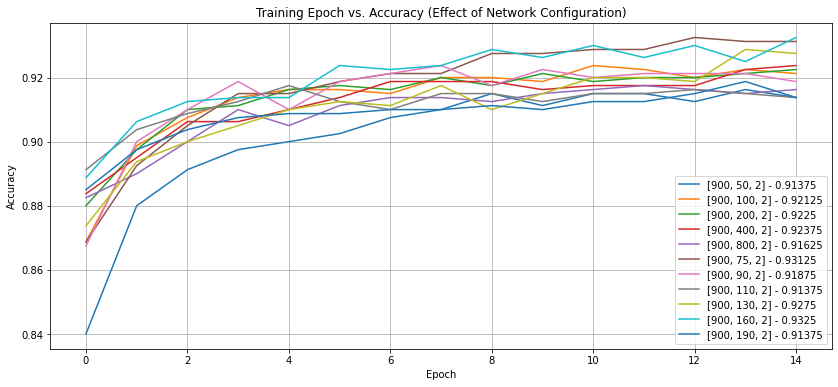

Best network configuration: [900, 160, 2]


In [2]:
def plot_accuracies_hidden_layers_and_nodes(save_dir, layers_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Network Configuration)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(
        f"Training Epoch vs. Accuracy (Effect of Network Configuration)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for layers in layers_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(layers, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=init_b,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{layers} => {final_score_avg} ({conv_time})')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = layers
        plt.plot(epoch_scores, label=f'{layers} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_layers_vs_acc', dpi=100)

    return best_config


layers_arr = [[ndimen, 50, 2],
              [ndimen, 100, 2],
              [ndimen, 200, 2],
              [ndimen, 400, 2],
              [ndimen, 800, 2],
              
              [ndimen, 75, 2],
              [ndimen, 90, 2],
              [ndimen, 110, 2],
              [ndimen, 130, 2],
              [ndimen, 160, 2],
              [ndimen, 190, 2], ]


best_nc = plot_accuracies_hidden_layers_and_nodes("img", layers_arr)
print(f"Best network configuration: {best_nc}")


# Tune Batch Size

Training Epoch vs. Accuracy (Effect of Batch Size)
5 => 0.93
8 => 0.93375
12 => 0.9175
14 => 0.9225
16 => 0.92875
18 => 0.9375
20 => 0.915
30 => 0.925
35 => 0.925
40 => 0.92625
45 => 0.92875
50 => 0.9275


KeyboardInterrupt: 

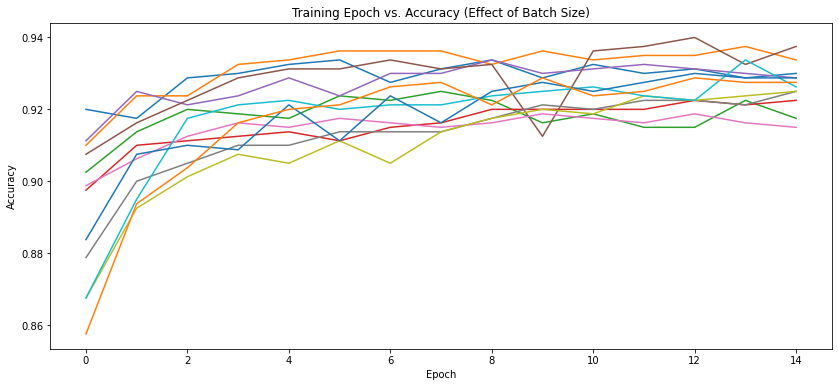

In [3]:
def plot_accuracies_mini_batch_size(save_dir, batch_size_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Batch Size)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Batch Size)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for batch_size in batch_size_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=batch_size,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{batch_size} => {final_score_avg} ({conv_time})')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = batch_size
        plt.plot(epoch_scores, label=f'{batch_size} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_batch_vs_acc', dpi=100)

    return best_config


batch_size_arr = [5, 8, 12, 14, 16, 18, 20, 30, 35, 40]
best_b = plot_accuracies_mini_batch_size("img", batch_size_arr)
print(f"Best batch size: {best_b}")

# Tune Learning Rate

Training Epoch vs. Accuracy (Effect of Learning Rate)
Training Epoch vs. Accuracy (Effect of Learning Rate)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0.75 => 0.91875


  0%|          | 0/15 [00:00<?, ?it/s]

0.65 => 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

0.6 => 0.93


  0%|          | 0/15 [00:00<?, ?it/s]

0.55 => 0.9275


  0%|          | 0/15 [00:00<?, ?it/s]

0.5 => 0.92375


  0%|          | 0/15 [00:00<?, ?it/s]

0.45 => 0.9325


  0%|          | 0/15 [00:00<?, ?it/s]

0.4 => 0.925


  0%|          | 0/15 [00:00<?, ?it/s]

0.35 => 0.91125


  0%|          | 0/15 [00:00<?, ?it/s]

0.25 => 0.93


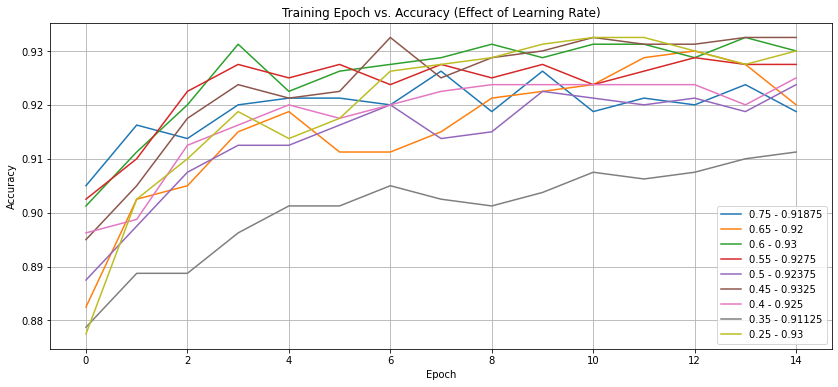

Best learning rate: 0.45


In [ ]:
def plot_accuracies_learning_rate(save_dir, learning_rate_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for learning_rate in learning_rate_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=best_b,
                                                                               learning_rate=learning_rate,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)

            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{learning_rate} => {final_score_avg} ({conv_time})')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = learning_rate

        plt.plot(epoch_scores, label=f'{learning_rate} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_lr_vs_acc', dpi=100)

    return best_config


learning_rate_arr = [0.75, 0.65, 0.60, 0.55, 0.5, 0.45, 0.40, 0.35, 0.25, 0.15, 0.1, 0.05, 0.01, 0.005, 0.001]
best_lr = plot_accuracies_learning_rate("img", learning_rate_arr)
print(f"Best learning rate: {best_lr}")

# Train Best Model

In [13]:
"""
Plot the convergence curve of BPNN
"""

training_data, validation_data, testing_data, ndimen = get_data()

max_epochs = 15
best_nc = [ndimen, 160, 2]
best_b = 5
best_lr = 0.5

print('# Best Hyperparameters:')
print(f' - Best Network Configuration: {best_nc}')
print(f' - Best Batch Size: {best_b}')
print(f' - Best Learning Rate: {best_lr}')


nn = BPNN(best_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, nn_conv_time = nn.train(training_data,
                                                                      max_epochs=max_epochs,
                                                                      batch_size=best_b,
                                                                      learning_rate=best_lr,
                                                                      evaluation_data=validation_data,
                                                                      evaluation_treshold=None)




# Best Hyperparameters:
 - Best Network Configuration: [900, 160, 2]
 - Best Batch Size: 5
 - Best Learning Rate: 0.5
# Training MLP Network: Sizes=[900, 160, 2]	Epochs=15	Batch-Size=5	Learning-Rate=0.5
 - Training Data Len: 10000
 - Validation Data Len: 800
# Epochs:
	1. Correct 725/800	(score: 0.90625	delta: 0.90625	delta_avg: 0.90625)
	2. Correct 742/800	(score: 0.9275	delta: 0.02124999999999999	delta_avg: 0.46375)
	3. Correct 736/800	(score: 0.92	delta: -0.007499999999999951	delta_avg: 0.3066666666666667)
	4. Correct 739/800	(score: 0.92375	delta: 0.00374999999999992	delta_avg: 0.2309375)
	5. Correct 743/800	(score: 0.92875	delta: 0.0050000000000000044	delta_avg: 0.18575)
	6. Correct 741/800	(score: 0.92625	delta: -0.0024999999999999467	delta_avg: 0.154375)
	7. Correct 737/800	(score: 0.92125	delta: -0.0050000000000000044	delta_avg: 0.13160714285714287)
	8. Correct 742/800	(score: 0.9275	delta: 0.006249999999999978	delta_avg: 0.1159375)


KeyboardInterrupt: 

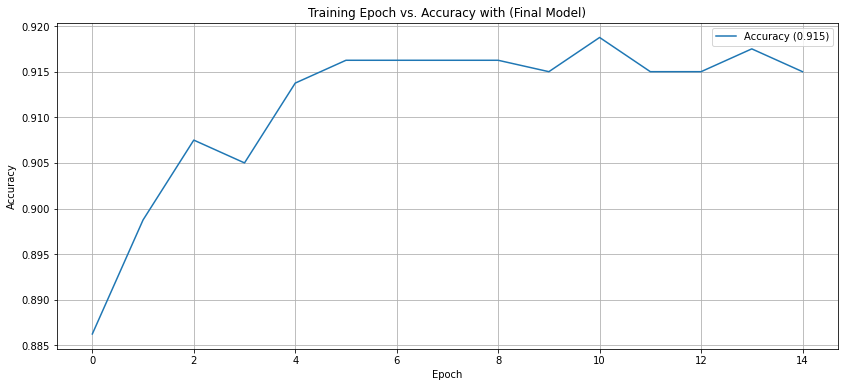

In [ ]:
fig = plt.figure(figsize=(14, 6))

plt.title(f"Training Epoch vs. Accuracy with (Final Model)")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')

plt.plot(eval_scores, label=f'Accuracy ({final_score})')

plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_best_model', dpi=100)

# Save Best Model & Predictions

In [ ]:
import gzip

# make directory to save generated images to
os.makedirs('models', exist_ok=True)

def save_best_model():
    # Save the best BPNN model to a pickle file
    with gzip.open('models/bpnn_best_model.pkl.gzip', 'wb') as f:
        pickle.dump(nn, f)
    
def save_testing_pred(data):
    # Tuples (X, y, y_pred)
    
    new_data = []
    for (x, y) in data:
        decision = np.argmax(nn.feedforward(x))
        new_data.append((x, y, decision))
        
    with gzip.open('models/bpnn_testing_pred.pkl.gzip', 'wb') as f:
        pickle.dump(new_data, f)


training_data, validation_data, testing_data, ndimen = get_data()
save_best_model()
save_testing_pred(testing_data)


# Load the Model

In [ ]:
# Load the best model from file
with gzip.open('models/bpnn_best_model.pkl.gzip', 'rb') as f:
    nn = pickle.load(f)

# Evaluate Model

In [ ]:
def evaluate(dataset, name):

    acc = 0
    acc0 = 0
    len0 = 0
    acc1 = 0
    len1 = 0

    for (x, y) in dataset:
        decision = np.argmax(nn.feedforward(x))

        if decision == y:
            acc += 1
        if y == 0:
            len0 += 1
            if decision == y:
                acc0 += 1
        if y == 1:
            len1 += 1
            if decision == y:
                acc1 += 1

    nn_acc = acc / (len0 + len1)
    # Compute class accuracies
    nn_acc0 = acc0 / len0
    nn_acc1 = acc1 / len1

    print(f'Overall {name} Accuracy: {nn_acc}')
    print(f'Class 0 {name} Accuracy: {nn_acc0}')
    print(f'Class 1 {name} Accuracy: {nn_acc1}')
    
    return nn_acc, nn_acc0, nn_acc1


training_data, validation_data, testing_data, ndimen = get_data()


vnn_acc, vnn_acc0, vnn_acc1 = evaluate(validation_data, "Validation")
print()
tnn_acc, tnn_acc0, tnn_acc1 = evaluate(testing_data, "Testing")



Overall Validation Accuracy: 0.91625
Class 0 Validation Accuracy: 0.8925
Class 1 Validation Accuracy: 0.94

Overall Testing Accuracy: 0.9183467741935484
Class 0 Testing Accuracy: 0.9155206286836935
Class 1 Testing Accuracy: 0.9213250517598344


# Plot Bar Chart

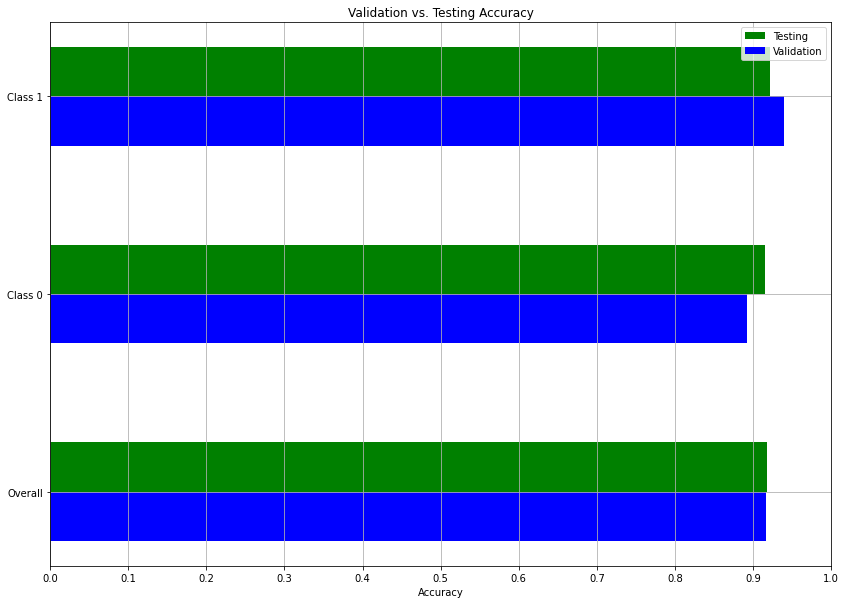

In [ ]:
# Plot a barchart comparing the validation vs testing accuracies overall, for class 0, and for class 1 side by side

# set the y axis major ticks to .1 and minor ticks to .01
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)



fig = plt.figure(figsize=(14, 10))

plt.title(f"Validation vs. Testing Accuracy")
plt.xlabel("Accuracy")

width = 0.25
plt.barh(0 + width/2, tnn_acc, width, label='Testing', color='green')
plt.barh(0 - width/2, vnn_acc, width, label='Validation', color='blue')

plt.barh(1 + width/2, tnn_acc0, width, color='green')
plt.barh(1 - width/2, vnn_acc0, width, color='blue')

plt.barh(2 + width/2, tnn_acc1, width, color='green')
plt.barh(2 - width/2, vnn_acc1, width, color='blue')

plt.yticks(np.arange(0, 3, 1), ['Overall', 'Class 0', 'Class 1'])
plt.xticks(major_ticks)
plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_validation_vs_testing', dpi=100)
